# lab5:检测社交媒体虚假账户
## 1.导入数据

In [100]:
# Run some setup code for this notebook.
import pandas as pd
import numpy as np
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
def load_data(path):
    df = pd.read_json(path)
    df_expanded = df['user'].apply(lambda x: pd.Series(x))
    df = pd.concat([df.drop('user', axis=1), df_expanded], axis=1)
    return df

data_train = load_data("./data/train.json") 
rawdata_test = load_data("./data/rawtest.json")
data_test = rawdata_test.copy()
data_train.shape, data_test.shape

((1986, 44), (250, 44))

## 2.数据预处理
我们首先把下面需要用到的函数封装为一个类型``preprocess``，这样我们就可以在后面的实验中直接调用这个类型的函数来进行数据预处理。

In [102]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
class preprocess:
    @staticmethod
    def parse_date(date_obj):
        """
        解析日期
        """
        return pd.Series({
            'year': date_obj.year,
            'month': date_obj.month,
            'day': date_obj.day,
            'hour': date_obj.hour,
            'minute': date_obj.minute,
            'second': date_obj.second,
            'weekday': date_obj.weekday(),  # 星期几，0表示星期一
            'day_of_year': date_obj.timetuple().tm_yday
        })
    @staticmethod
    def str_similarit(s1, s2):
        """
        计算两个字符串的相似度
        """
        return cosine_similarity(CountVectorizer().fit_transform([s1, s2]))[0][1]
    @staticmethod
    def extract_tld(url):
        """
        提取域名后缀
        """
        # 正则表达式匹配域名后缀
        pattern = r'\.([a-zA-Z]+)(?:[/\s]|$)'
        match = re.search(pattern, url)
        if match:
            # 返回匹配的后缀
            return match.group(1)
        else:
            # 如果没有匹配，返回 None
            return None
    @staticmethod
    def label_encode(strr):
        """
        对指定列进行标签编码
        """
        if strr == 'bot':
            return 1
        else:
            return 0


### 1.删除低质量的样本和特征
我们认为样本的完整性表明了样本质量,因此如果一个特征的缺失值超过50%，则删除该特征。如果一个样本的缺失值超过50%，则删除该样本。

In [103]:
# 遍历训练集的每一行(每个样本),把特征空值数目超过一半的样本删除
data_train = data_train.dropna(axis=0, thresh=22)
feature_list = data_train.columns.tolist()
data_train.shape

(1986, 44)

In [104]:
# 遍历训练集的每一列(每个特征),把特征空值数目超过一半的特征删除,并记录删除的特征名
drop_features = []
data_train = data_train.dropna(axis=1, thresh=993, inplace=False)
feature_list_new = data_train.columns.tolist()
drop_features = list(set(feature_list) - set(feature_list_new))
print(drop_features, data_train.shape)


['time_zone', 'utc_offset'] (1986, 42)


In [105]:
data_test = data_test.drop(drop_features, axis=1, inplace=False)

In [106]:
print(data_train.columns)
print(data_test.columns)

Index(['created_at', 'label', 'id', 'id_str', 'name', 'screen_name',
       'location', 'description', 'url', 'entities', 'protected',
       'followers_count', 'friends_count', 'listed_count', 'created_at',
       'favourites_count', 'geo_enabled', 'verified', 'statuses_count', 'lang',
       'contributors_enabled', 'is_translator', 'is_translation_enabled',
       'profile_background_color', 'profile_background_image_url',
       'profile_background_image_url_https', 'profile_background_tile',
       'profile_image_url', 'profile_image_url_https', 'profile_banner_url',
       'profile_link_color', 'profile_sidebar_border_color',
       'profile_sidebar_fill_color', 'profile_text_color',
       'profile_use_background_image', 'has_extended_profile',
       'default_profile', 'default_profile_image', 'following',
       'follow_request_sent', 'notifications', 'translator_type'],
      dtype='object')
Index(['created_at', 'label', 'id', 'id_str', 'name', 'screen_name',
       'location'

### 2.特征分析与类型转换
首先合并重复列,如果有列名相同,只保留第一列

In [107]:
# 遍历每一列,如果遇到后面的列名称与前面的列相同,则删除后面的列
data_train = data_train.loc[:, ~data_train.columns.duplicated()]
print(data_train.shape)
data_test = data_test.loc[:, ~data_test.columns.duplicated()]
print(data_test.shape)

(1986, 41)
(250, 41)


``created_at``我们把它转换为数值类型

In [108]:
data_train['created_at'] = pd.to_datetime(data_train['created_at'])
data_features = data_train['created_at'].apply(lambda x: preprocess.parse_date(x))
data_train=data_train.drop(['created_at'],axis=1)
data_train=data_train.join(data_features)

data_test['created_at'] = pd.to_datetime(data_test['created_at'])
data_features = data_test['created_at'].apply(lambda x: preprocess.parse_date(x))
data_test=data_test.drop(['created_at'],axis=1)
data_test=data_test.join(data_features)

接下来有四个特征,``id``,``id_str``,``name``,``screen_name``,我们认为这四个特征起到的作用可以用两个特征来描述:  
1. ``id``: 用户的唯一标识符,用于区分不同的用户  
2. ``name_corr``: 用户``name``和``screen_name``的相似度,用于区分虚假账户和真实账户

In [109]:
# 首先删去id_str列
data_train = data_train.drop(['id_str'], axis=1)
# 对于每一行,计算name和screen_name的相似度,并添加到data_train中
data_train['name_corr'] = data_train.apply(lambda x: preprocess.str_similarit(x['name'], x['screen_name']), axis=1)
# 删去name列和screen_name列
data_train = data_train.drop(['name', 'screen_name'], axis=1)

# 首先删去id_str列
data_test = data_test.drop(['id_str'], axis=1)
# 对于每一行,计算name和screen_name的相似度,并添加到data_test中
data_test['name_corr'] = data_test.apply(lambda x: preprocess.str_similarit(x['name'], x['screen_name']), axis=1)
# 删去name列和screen_name列
data_test = data_test.drop(['name', 'screen_name'], axis=1)

接下来是特征``location``,做独热编码

In [110]:
# 对location进行独热编码
data_train = data_train.join(pd.get_dummies(data_train['location'], prefix='location'))
data_train = data_train.drop(['location'], axis=1)

# 对location进行独热编码
data_test = data_test.join(pd.get_dummies(data_test['location'], prefix='location'))
data_test = data_test.drop(['location'], axis=1)

特征``description``我们认为是文本特征,我们先把它放在一边,稍后处理

对于``url``这个特征,我们认为域名后缀是一个重要的特征,因此我们把它提取出来,并且把它转换为浮点型

In [111]:
# 首先找到所有含有url的列
url_cols = [col for col in data_train.columns if 'url' in col]
# 对每一个含有url的列用正则表达式提取域名后缀
for col in url_cols:
    data_train[col] = data_train[col].apply(lambda x: preprocess.extract_tld(x) if isinstance(x, str) else x)
# 对提取后的域名后缀进行独热编码
data_train = data_train.join(pd.get_dummies(data_train[url_cols], prefix='url'))
# 删除原始的url列
data_train = data_train.drop(url_cols, axis=1)

# 首先找到所有含有url的列
url_cols = [col for col in data_test.columns if 'url' in col]
# 对每一个含有url的列用正则表达式提取域名后缀
for col in url_cols:
    data_test[col] = data_test[col].apply(lambda x: preprocess.extract_tld(x) if isinstance(x, str) else x)
# 对提取后的域名后缀进行独热编码
data_test = data_test.join(pd.get_dummies(data_test[url_cols], prefix='url'))
# 删除原始的url列
data_test = data_test.drop(url_cols, axis=1)

对于``entities``这个特征,考虑到它本身结构比较复杂,我们只区分是否为空,因此我们把它转换为0-1型

In [112]:
# 处理entities列,区分其内部的description和url是否为空,只要有一个不为空,则置为1,否则置为0
data_train['entities'] = data_train['entities'].apply(lambda x: 1 if x['description'] or x['url'] else 0)

# 处理entities列,区分其内部的description和url是否为空,只要有一个不为空,则置为1,否则置为0
data_test['entities'] = data_test['entities'].apply(lambda x: 1 if x['description'] or x['url'] else 0)

接下来处理bool类型的特征,我们把它们转换为0和1

In [113]:
# 找到所有bool类型的列
bool_cols = data_train.select_dtypes(include=['bool']).columns

# 将bool类型的列转换为int类型
for col in bool_cols:
    data_train[col] = data_train[col].astype(int)

# 找到所有bool类型的列
bool_cols = data_test.select_dtypes(include=['bool']).columns

# 将bool类型的列转换为int类型
for col in bool_cols:
    data_test[col] = data_test[col].astype(int)

接下来处理``lang``和包含color的列,以及``translator_type``,我们采用独热编码。我们认为color列对于虚假账户的检测是没有意义的,因此我们把它删除

In [114]:
# 对lang进行独热编码
data_train = data_train.join(pd.get_dummies(data_train['lang'], prefix='lang'))
data_train = data_train.drop(['lang'], axis=1)
# 找出所有包含color的列
color_cols = [col for col in data_train.columns if 'color' in col]
# 原始的color列
data_train = data_train.drop(color_cols, axis=1)
# 对translator_type进行独热编码
data_train = data_train.join(pd.get_dummies(data_train['translator_type'], prefix='translator_type'))
data_train = data_train.drop(['translator_type'], axis=1)

# 对lang进行独热编码
data_test = data_test.join(pd.get_dummies(data_test['lang'], prefix='lang'))
data_test = data_test.drop(['lang'], axis=1)
# 找出所有包含color的列
color_cols = [col for col in data_test.columns if 'color' in col]
# 原始的color列
data_test = data_test.drop(color_cols, axis=1)
# 对translator_type进行独热编码
data_test = data_test.join(pd.get_dummies(data_test['translator_type'], prefix='translator_type'))
data_test = data_test.drop(['translator_type'], axis=1)

最后我们对标签进行编码,``bot``为1,``human``为0

In [115]:
# 对标签编码,遍历label列,如果是bot,则置为1,否则置为0
data_train['label'] = data_train['label'].apply(lambda x: preprocess.label_encode(x))

# 对标签编码,遍历label列,如果是bot,则置为1,否则置为0
data_test['label'] = data_test['label'].apply(lambda x: preprocess.label_encode(x))

接下来我们做一个阶段性检查

In [116]:
# 找出所有不是数值类型的列
non_numeric_cols = data_train.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)

non_numeric_cols = data_test.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)

Index(['description'], dtype='object')
Index(['description'], dtype='object')


最后我们来处理文本特征``description``,我们首先将``description``中的缺失值填充为``unknown``,然后把``description``和``label``这两列单独拿出来

In [117]:
# 把description列中的空值填充为'unknown'
data_train['description'] = data_train['description'].fillna('unknown')
# 单独拿出description和label列
data_description = data_train[['description', 'label']]

通过对这个子数据集进行分析,我们最终决定放弃这个特征,具体的分析和原因见实验报告

In [118]:
# 删掉description列
data_train = data_train.drop(['description'], axis=1)
data_test = data_test.drop(['description'], axis=1)
print(data_train.columns)
print(data_test.columns)

Index(['label', 'id', 'entities', 'protected', 'followers_count',
       'friends_count', 'listed_count', 'favourites_count', 'geo_enabled',
       'verified',
       ...
       'lang_ko', 'lang_nl', 'lang_pl', 'lang_pt', 'lang_ru', 'lang_th',
       'lang_tr', 'translator_type_badged', 'translator_type_none',
       'translator_type_regular'],
      dtype='object', length=1177)
Index(['label', 'id', 'entities', 'protected', 'followers_count',
       'friends_count', 'listed_count', 'favourites_count', 'geo_enabled',
       'verified',
       ...
       'lang_id', 'lang_it', 'lang_ja', 'lang_ko', 'lang_pt', 'lang_th',
       'lang_tr', 'translator_type_badged', 'translator_type_none',
       'translator_type_regular'],
      dtype='object', length=229)


### 3.数据归一化
方便后面模型的训练,我们对数据进行归一化.在此之前,我们首先检查是否存在整列值相同的列,如果存在,则删除这些列

In [119]:
# 检查是否有某一列的值全相同(标准差为0),如果有,则删除该列
data_train = data_train.loc[:, data_train.std() != 0]
print(data_train.shape)

# 检查是否有某一列的值全相同(标准差为0),如果有,则删除该列
data_test = data_test.loc[:, data_test.std() != 0]
print(data_test.shape)

(1986, 1170)
(250, 220)


In [120]:
# 如果一个特征在训练集中存在,但是在测试集中不存在,则在测试集中添加该特征,并用0填充
for col in data_train.columns:
    if col not in data_test.columns:
        data_test[col] = 0
# 如果一个特征仅在测试集中存在,删掉该特征
for col in data_test.columns:
    if col not in data_train.columns:
        data_test = data_test.drop([col], axis=1)
data_train = data_train.loc[:, ~data_train.columns.duplicated()]
print(data_train.shape)
data_test = data_test.loc[:, ~data_test.columns.duplicated()]
print(data_test.shape)
# 调整训练集和测试集的列顺序,使得两者的列顺序一致
data_test = data_test[data_train.columns]

C:\Users\86135\AppData\Local\Temp\ipykernel_21324\367313339.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_test[col] = 0
C:\Users\86135\AppData\Local\Temp\ipykernel_21324\367313339.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_test[col] = 0
C:\Users\86135\AppData\Local\Temp\ipykernel_21324\367313339.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

(1986, 1167)
(250, 1167)


In [121]:
# 保存未归一化的数据
data_train.to_csv('./data/data_train.csv', index=False)

对每列数据进行归一化:$data=\frac{data-min}{max-min}$

In [122]:
# 对每列数据进行归一化
data_train_normalized = (data_train - data_train.min()) / (data_train.max() - data_train.min())
# 保存归一化后的数据
data_train_normalized.to_csv('./data/data_train_normalized.csv', index=False)

### 4.特征选择与数据可视化
我们首先把特征和标签分开

In [123]:
# 分开特征和标签
X = data_train_normalized.drop(['label'], axis=1)
y = data_train_normalized['label']
# 统计正负样本个数
print(y.value_counts())

0.0    1130
1.0     856
Name: label, dtype: int64


正负样本数比较均衡

考虑到数据集不是很大,我们决定保留所有的特征

接下来我们使用t-SNE进行降维,并可视化数据集

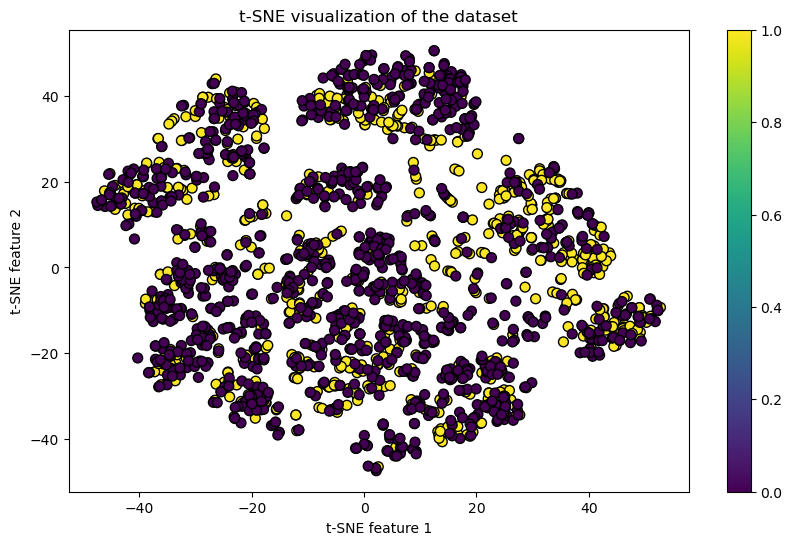

In [124]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 X 是您的特征矩阵，y 是目标变量
# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.colorbar()
plt.title('t-SNE visualization of the dataset')
plt.show()

特征图看起来在高维空间中才能分开

### 5.数据集划分
采用交叉验证法,把数据均匀分成5份,每次按照4:1的比例划分训练集和测试集

In [125]:
# 打乱数据集,然后均分成5份
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [126]:
# 记录模型的结果
model_results = []

## 3.模型构建与训练
每次选择4份数据进行训练,1份数据用于测试,最后取平均值,输出格式为:$acc\pm \sigma$
### 1.Logistic Regression

In [127]:
# 导入模型
from sklearn.linear_model import LogisticRegression
# 采用交叉验证法,每次按4:1的比例划分训练集和验证集,输出平均正确率
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr = LogisticRegression(max_iter=1000, C=1.2)
    lr.fit(X_train, y_train)
    acc.append(lr.score(X_test, y_test))
print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(acc), np.std(acc)))
model_results.append(['LogisticRegression', np.mean(acc)])

Accuracy: 0.712 ± 0.017


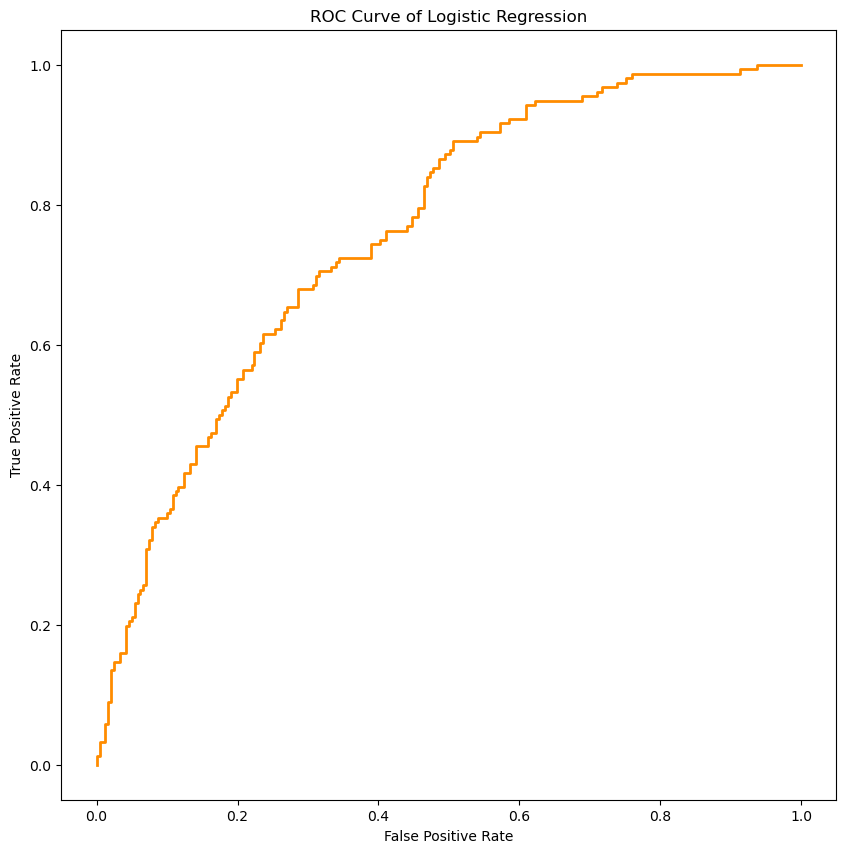

In [128]:
# 画出ROC曲线
from sklearn.metrics import roc_curve, auc
lr = LogisticRegression(max_iter=1000, C=1.2)
lr.fit(X_train, y_train)
y_score = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))

### 2.Decision Tree

In [129]:
# 使用决策树模型
from sklearn.tree import DecisionTreeClassifier
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(X_train, y_train)
    acc.append(dt.score(X_test, y_test))
print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(acc), np.std(acc)))
model_results.append(['DecisionTreeClassifier', np.mean(acc)])

Accuracy: 0.729 ± 0.018


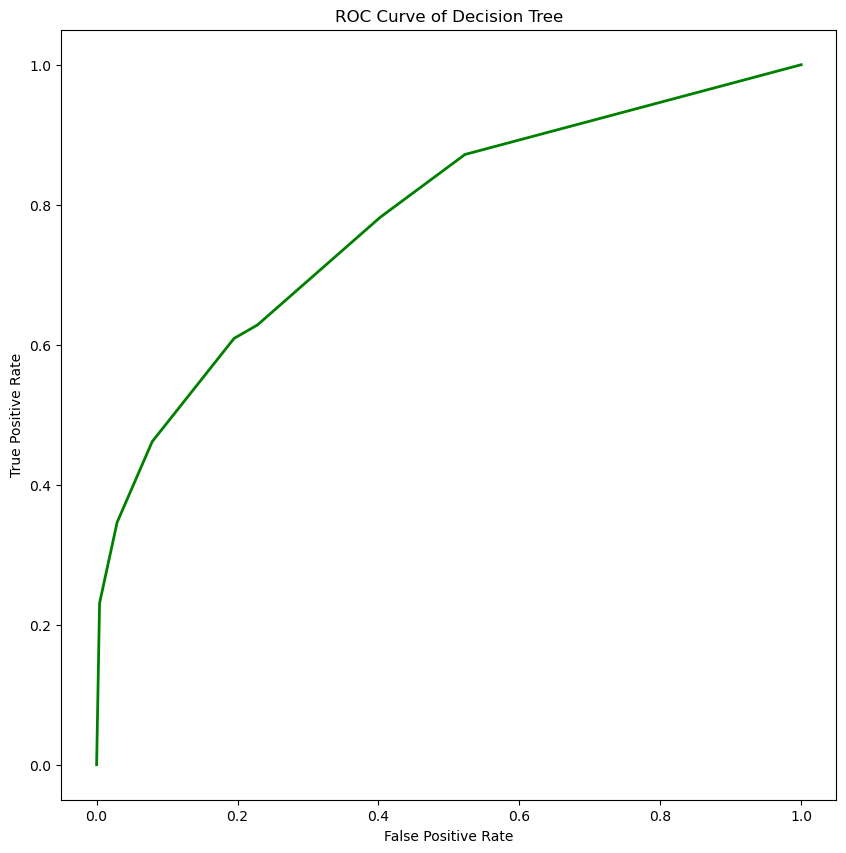

In [130]:
# 画出ROC曲线
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
y_score = dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))

### 3.Random Forest

In [131]:
# 使用随机森林模型
from sklearn.ensemble import RandomForestClassifier
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    acc.append(rf.score(X_test, y_test))
print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(acc), np.std(acc)))
model_results.append(['RandomForestClassifier', np.mean(acc)])

Accuracy: 0.775 ± 0.024


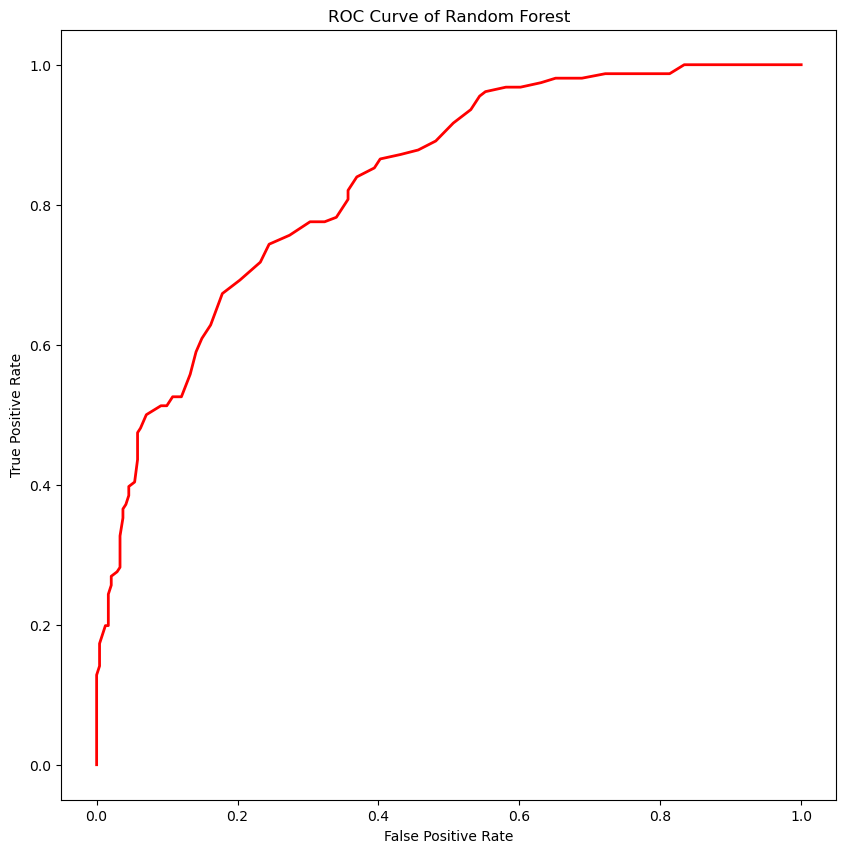

In [132]:
# 画出ROC曲线
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_score = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))

### 4.SVM

In [133]:
# 使用SVM模型
from sklearn.svm import SVC
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    svc = SVC(kernel='linear',C=1.2)
    svc.fit(X_train, y_train)
    acc.append(svc.score(X_test, y_test))
print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(acc), np.std(acc)))
model_results.append(['SVC', np.mean(acc)])

Accuracy: 0.717 ± 0.013


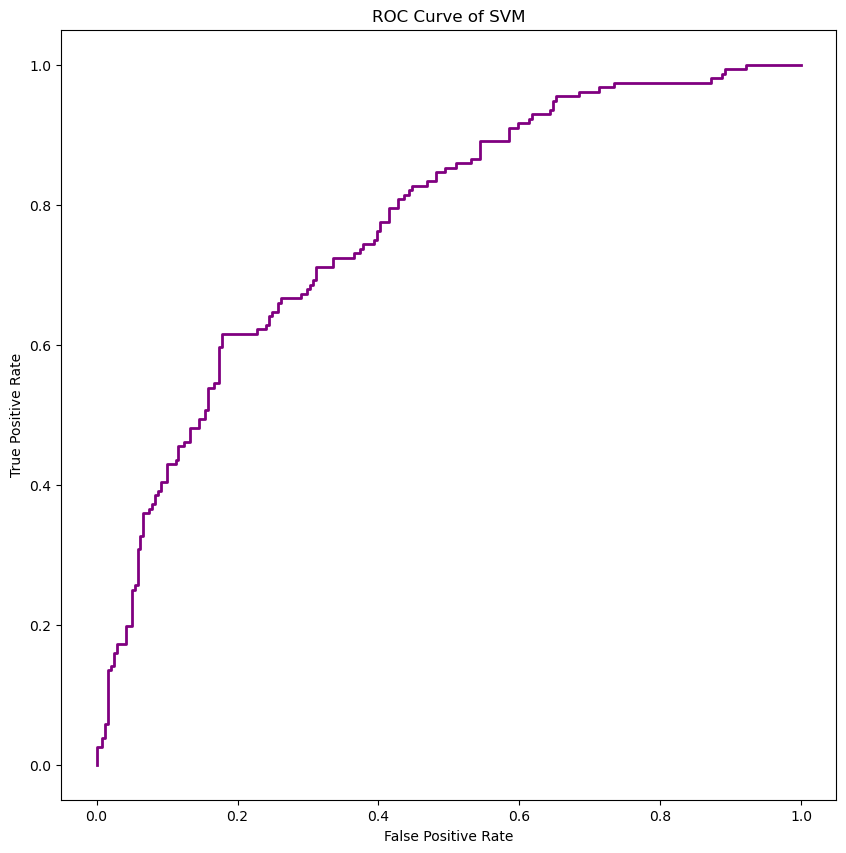

In [134]:
# 画出ROC曲线
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_score = svc.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SVM')
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))

### 5.AdaBoost

In [135]:
# 使用AdaBoost模型
from sklearn.ensemble import AdaBoostClassifier
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ada = AdaBoostClassifier()
    ada.fit(X_train, y_train)
    acc.append(ada.score(X_test, y_test))
print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(acc), np.std(acc)))
model_results.append(['AdaBoostClassifier', np.mean(acc)])

Accuracy: 0.760 ± 0.015


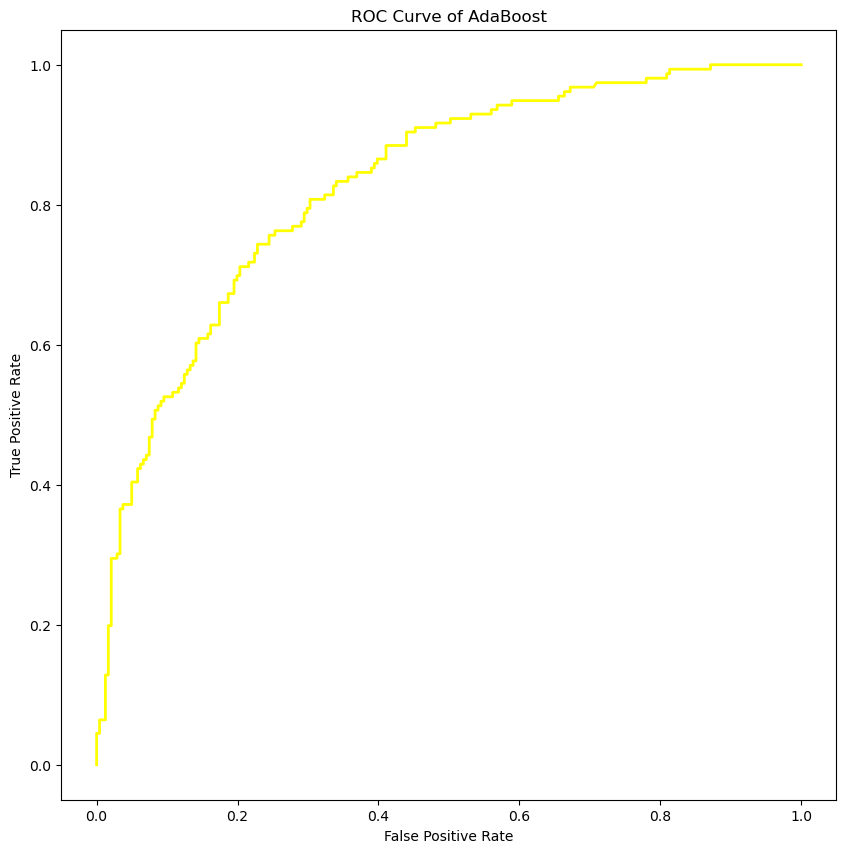

In [136]:
# 画出ROC曲线
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_score = ada.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of AdaBoost')
plt.plot(fpr, tpr, color='yellow', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))

### 6.GBDT

In [137]:
# 使用GBDT模型
from sklearn.ensemble import GradientBoostingClassifier
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gbdt = GradientBoostingClassifier()
    gbdt.fit(X_train, y_train)
    acc.append(gbdt.score(X_test, y_test))
print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(acc), np.std(acc)))
model_results.append(['GradientBoostingClassifier', np.mean(acc)])

Accuracy: 0.769 ± 0.023


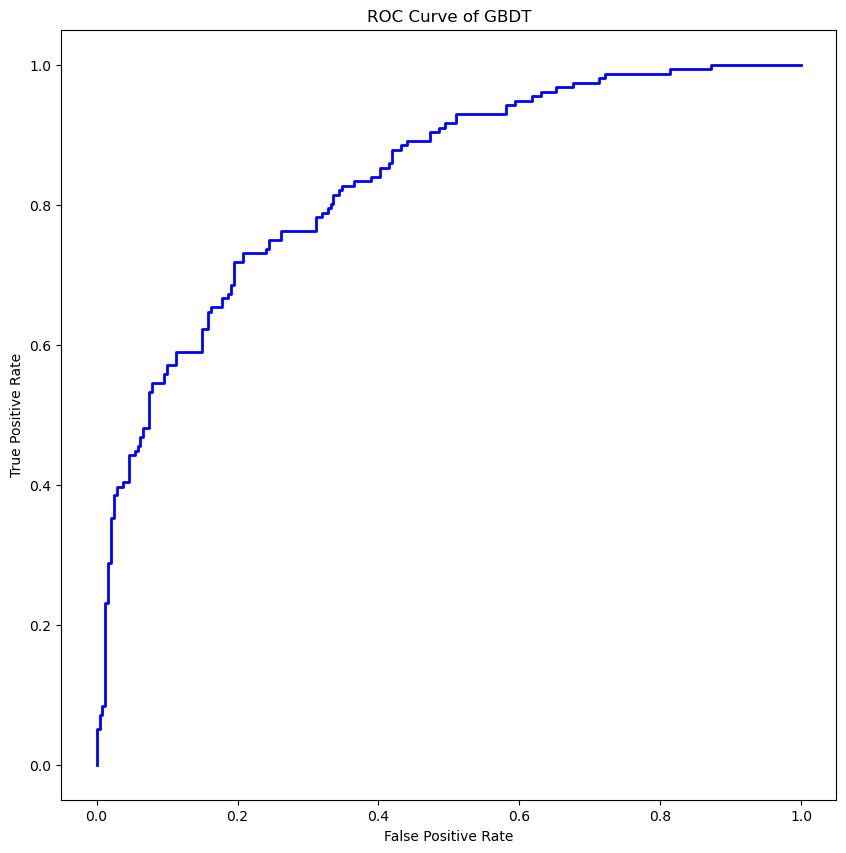

In [138]:
# 画出ROC曲线
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train)
y_score = gbdt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of GBDT')
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))

### 7.神经网络

In [139]:
# 使用三层全连接神经网络
from sklearn.neural_network import MLPClassifier
acc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, alpha=1)
    mlp.fit(X_train, y_train)
    acc.append(mlp.score(X_test, y_test))
print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(acc), np.std(acc)))
model_results.append(['MLPClassifier', np.mean(acc)])

Accuracy: 0.717 ± 0.018


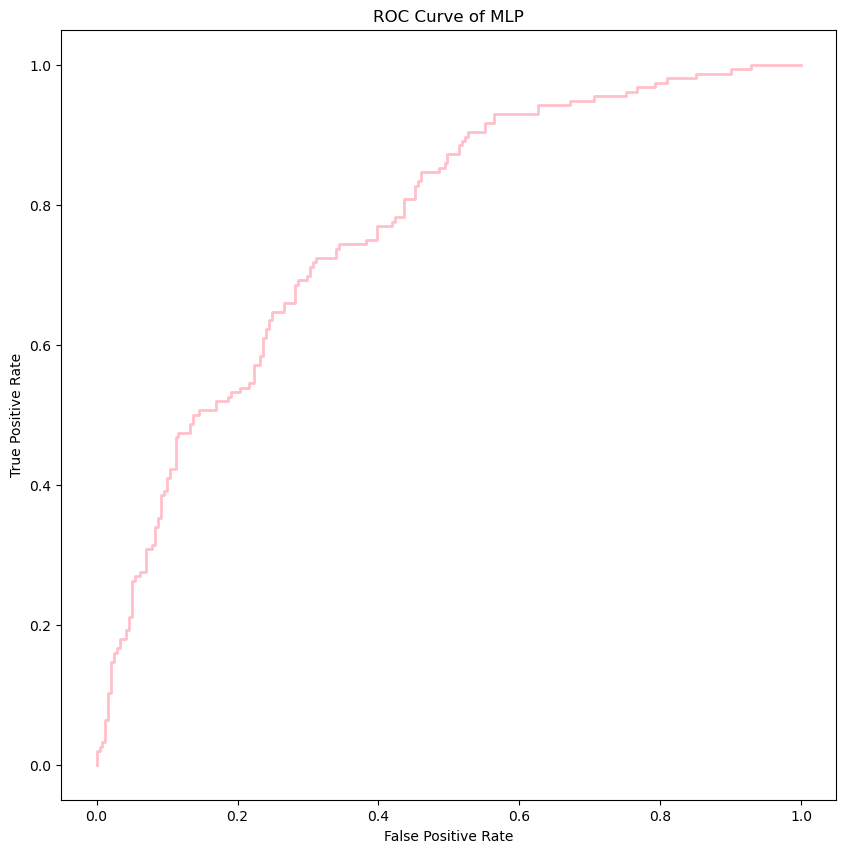

In [140]:
# 画出ROC曲线
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, alpha=1)
mlp.fit(X_train, y_train)
y_score = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MLP')
plt.plot(fpr, tpr, color='pink', lw=2, label='ROC curve (area = {:.3f})'.format(roc_auc))

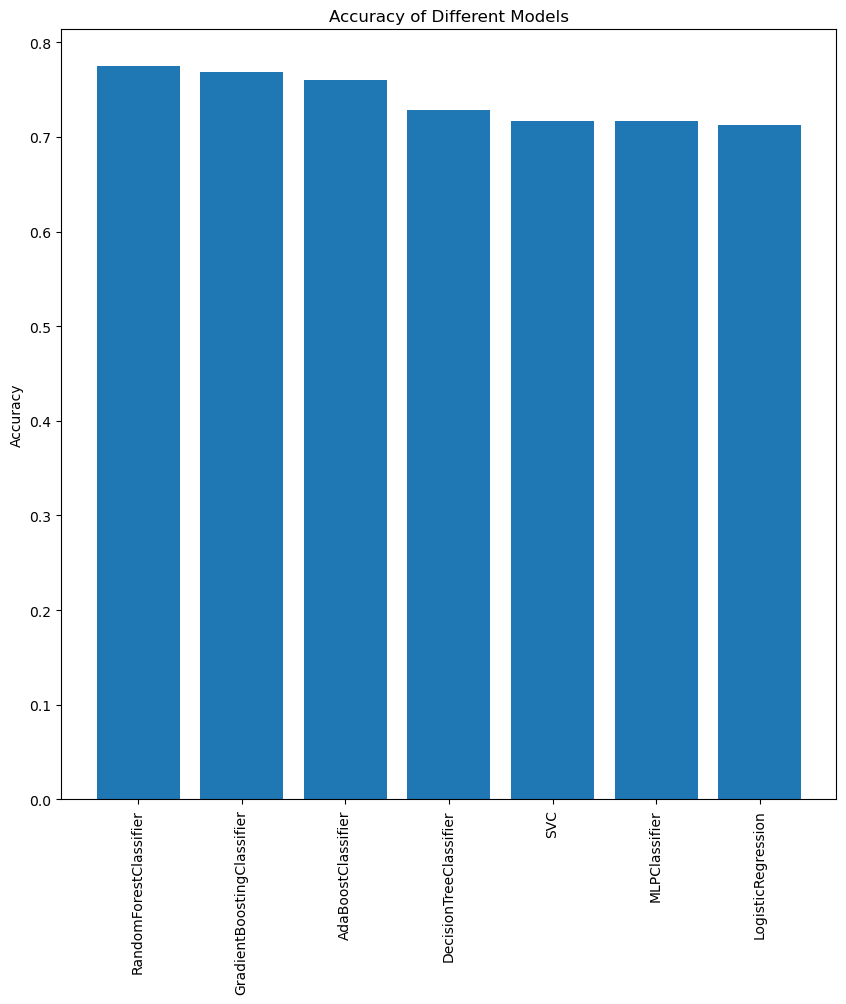

In [141]:
# 根据model_results中的结果,画出模型的准确率柱状图
model_results = pd.DataFrame(model_results, columns=['model', 'accuracy'])
model_results = model_results.sort_values(by='accuracy', ascending=False)
plt.figure(figsize=(10, 10))
plt.bar(model_results['model'], model_results['accuracy'])
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.show()

## 4.构建最终的分类器
比较上述模型的性能,我们选择RandomForest作为最终的分类器

In [142]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

画出特征重要性分布图(取前20个特征)

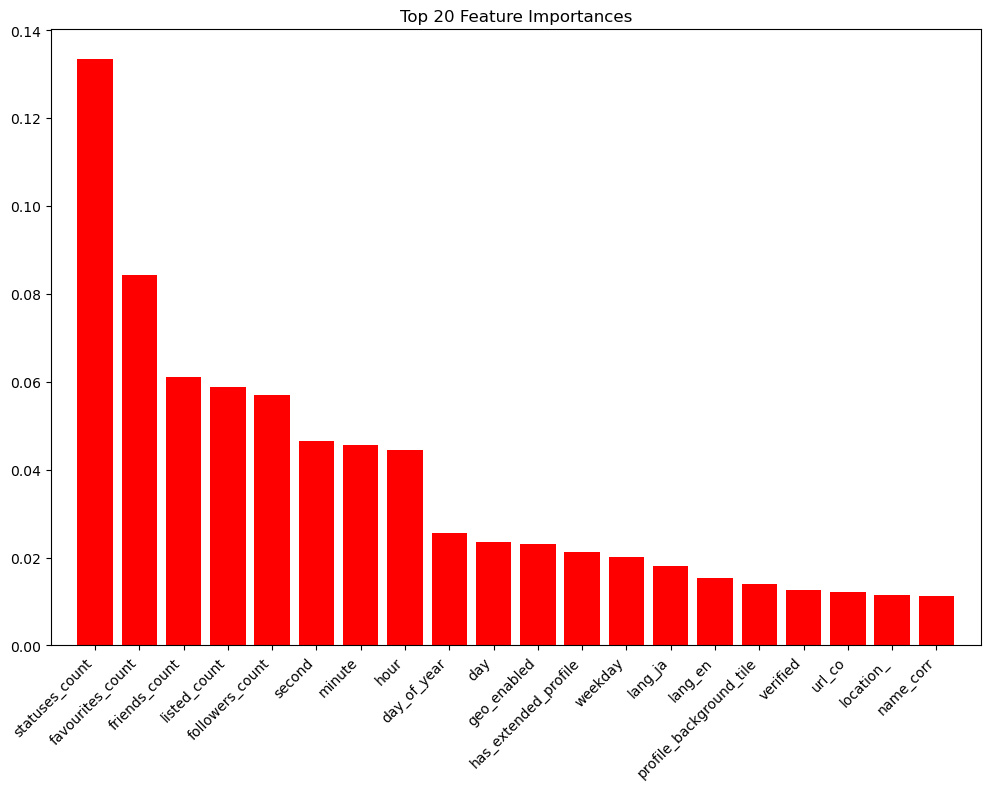

In [143]:
importances = RF.feature_importances_
feature_names = X_train.columns
# 对特征重要性进行排序
indices = np.argsort(importances)[::-1]
top_n = 20
top_indices = indices[:top_n]
top_sorted_feature_names = [feature_names[i] for i in top_indices]
top_sorted_importances = importances[top_indices]
plt.figure(figsize=(12, 8))  # 调整大小以适应更多的特征名称
plt.title("Top 20 Feature Importances")
plt.bar(range(top_n), top_sorted_importances, color="r", align="center")
plt.xticks(range(top_n), top_sorted_feature_names, rotation=45, ha='right')  # 旋转标签以便清晰显示
plt.xlim([-1, top_n])
plt.show()

下面我们导入测试集

In [144]:
# 删除测试集的label列
data_test = data_test.drop(['label'], axis=1)
# 检查是否有某一列的值全相同(标准差为0),如果有,记录该列名
drop_features = []
for col in data_test.columns:
    if data_test[col].std() == 0:
        drop_features.append(col)
# 归一化,对不在drop_features中的列进行归一化
for col in data_test.columns:
    if col not in drop_features:
        data_test[col] = (data_test[col] - data_test[col].min()) / (data_test[col].max() - data_test[col].min())
data_test_normalized = data_test

接下来我们对测试集进行预测,并输出结果

In [145]:
# 使用RandomForest模型进行预测
y_pred = RF.predict(data_test_normalized)
print(y_pred)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.]


填入预测结果

In [146]:
import json

# 读取 rawtest.json 文件
with open('./data/rawtest.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

assert len(data) == len(y_pred), "预测结果的数量必须与测试集中的记录数量相匹配"

# 遍历数据，填写 label
for i, record in enumerate(data):
    label = 'bot' if y_pred[i] == 1 else 'human'
    record['label'] = label

# 将结果保存到 test.json 文件
with open('./data/test.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)